In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/My Drive/DeepLearning/final_project/')

Mounted at /content/gdrive


In [0]:
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time
from scipy import ndimage

from skimage.filters import sobel
from skimage.measure import label
from skimage.segmentation import slic, join_segmentations
from skimage.morphology import watershed
from skimage.color import label2rgb
from skimage import data

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy import ndimage as ndi
import cv2
import pandas as pd

In [55]:
grade = pd.read_csv('warwick_data/Grade.csv')
#grade.loc['name'].startswith('testA')
print('number of testA images: ',len(grade.loc[(grade['name'].str.startswith('testA_'))]))
print('number of testB images: ',len(grade.loc[(grade['name'].str.startswith('testB_'))]))
print('number of train images: ',len(grade.loc[(grade['name'].str.startswith('train_'))]))
#grade.sample(10)
for idx,row in grade.iteritems():
    print(row)

number of testA images:  60
number of testB images:  20
number of train images:  85
0       testA_1
1      testA_10
2      testA_11
3      testA_12
4      testA_13
5      testA_14
6      testA_15
7      testA_16
8      testA_17
9      testA_18
10     testA_19
11      testA_2
12     testA_20
13     testA_21
14     testA_22
15     testA_23
16     testA_24
17     testA_25
18     testA_26
19     testA_27
20     testA_28
21     testA_29
22      testA_3
23     testA_30
24     testA_31
25     testA_32
26     testA_33
27     testA_34
28     testA_35
29     testA_36
         ...   
135     train_6
136    train_60
137    train_61
138    train_62
139    train_63
140    train_64
141    train_65
142    train_66
143    train_67
144    train_68
145    train_69
146     train_7
147    train_70
148    train_71
149    train_72
150    train_73
151    train_74
152    train_75
153    train_76
154    train_77
155    train_78
156    train_79
157     train_8
158    train_80
159    train_81
160    train_82
161 

In [0]:
def label_cat (row):
  if row['name'].startswith('testA_') :
    return 'testA'
  elif row['name'].startswith('testB_') :
    return 'testB'
  elif row['name'].startswith('train'):
    return 'train'
  else:
    return 'Other'

In [0]:
grade['name_label'] = grade.apply (lambda row: label_cat(row), axis=1)


In [60]:
grade.columns

Index(['name', 'patient ID', ' grade (GlaS)',
       ' grade (Sirinukunwattana et al. 2015)', 'name_label'],
      dtype='object')

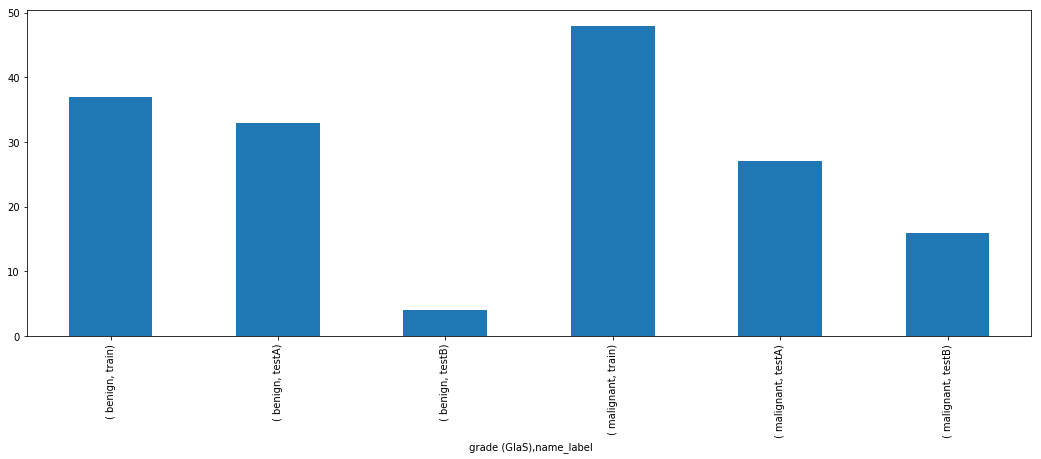

In [66]:
grade['name_label'].groupby(grade[' grade (GlaS)']).value_counts().plot(kind='bar');

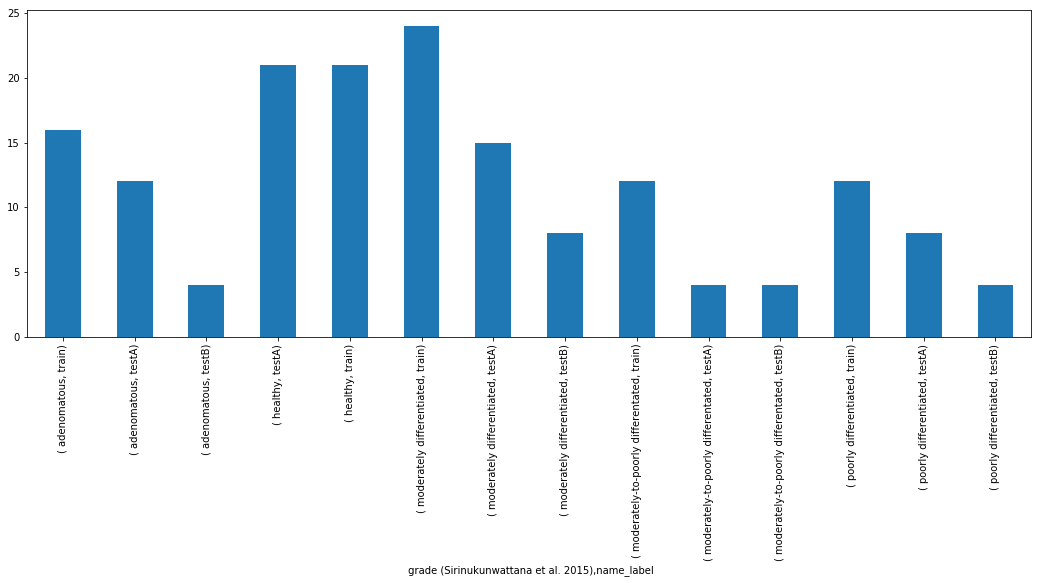

In [67]:
grade['name_label'].groupby(grade[' grade (Sirinukunwattana et al. 2015)']).value_counts().plot(kind='bar');

# Loading the data
TODO:
  * We need to make sure that the data is loaded correctly, since there are different names
    * Test A
    * Test B
    * Train 
    
    Maybe we could ask Peter about that...
  * Increase size to original size and test if we can get better results

In [0]:

images = []
masks = []
size=(256,256) # original size is 576x576 -> maybe increas it for later tests
for root, dirs, files in os.walk('warwick_data/'):
   for f in files:
      if not f.endswith('anno.bmp') and not f.endswith('csv'):
        img_path = f
        images.append(resize(imread(os.path.join(root, img_path)), size, mode='constant',anti_aliasing=True))
        
        mask_path = f[:-4]+'_anno.bmp'
        masks.append(resize(imread(os.path.join(root, mask_path)), size, mode='constant',anti_aliasing=True))


In [9]:
X = np.array(images, np.float32)
Y = np.array(masks, np.float32)
print('Loaded %d images' % len(X))
print('Loaded %d masks' % len(Y))


Loaded 165 images
Loaded 165 masks


# Data augmentation
  + horizontal flip
  + vertical flip
  

In [10]:
data_aug_on = True
if data_aug_on:
  X=np.concatenate((X,np.flipud(X)))
  X=np.concatenate((X,np.fliplr(X)))

  Y=np.concatenate((Y,np.flipud(Y)))
  Y=np.concatenate((Y,np.fliplr(Y)))
  print('Loaded %d images' % len(X))
  print('Loaded %d masks' % len(Y))

Loaded 660 images
Loaded 660 masks


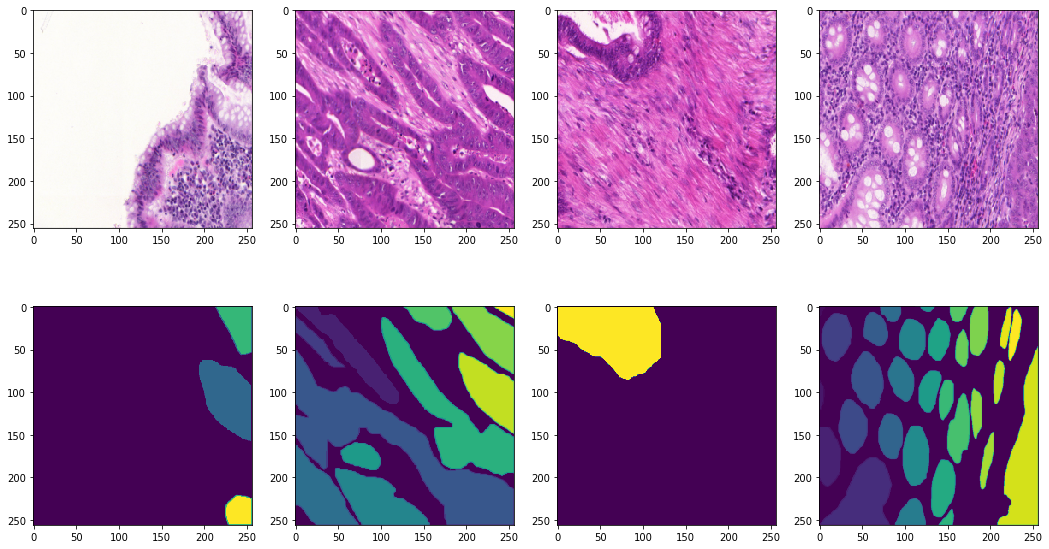

In [11]:

plt.rcParams['figure.figsize'] = [18, 10]

for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(X[i])

    plt.subplot(2, 4, i+5)
    plt.imshow(Y[i])


plt.show();

In [0]:
ix = np.random.choice(len(X), len(X), False)
#print(ix)
tr, val = np.split(ix, [int(len(X)/3*2)]) # set better values

In [13]:
print(len(tr), len(val))

440 220


In [0]:
batch_size = 6
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])), batch_size=batch_size, shuffle=False)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [16]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool0 = nn.MaxPool2d(3, 2, padding=1)  # 256 -> 128
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(3, 2, padding=1)  # 128 -> 64
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(3, 2, padding=1)  # 64 -> 32
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(3, 2, padding=1)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv0 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.upsample1 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv1 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.upsample2 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.upsample3 = nn.Upsample(256)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(64*2, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        #print(x.size())
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        #print(x.size())

        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(torch.cat([b,e3],1))))
        d1 = F.relu(self.dec_conv1(self.upsample1(torch.cat([d0,e2],1))))
        d2 = F.relu(self.dec_conv2(self.upsample2(torch.cat([d1,e1],1))))
        d3 = self.dec_conv3(self.upsample3(torch.cat([d2,e0],1)))

        return d3

In [0]:
def bce_loss(y_real, y_pred):
    return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))

In [0]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print(' - loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = torch.sigmoid(model(X_val.to(device))).detach().cpu()
        clear_output(wait=True)
        plt.rcParams['figure.figsize'] = [18, 6]
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

In [0]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [torch.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]
    return np.array(Y_pred)

In [21]:
model = UNet().to(device)
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
         MaxPool2d-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,928
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,928
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          36,928
         Upsample-10          [-1, 128, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          73,792
         Upsample-12          [-1, 128, 64, 64]               0
           Conv2d-13           [-1, 64, 64, 64]          73,792
         Upsample-14        [-1, 128, 1

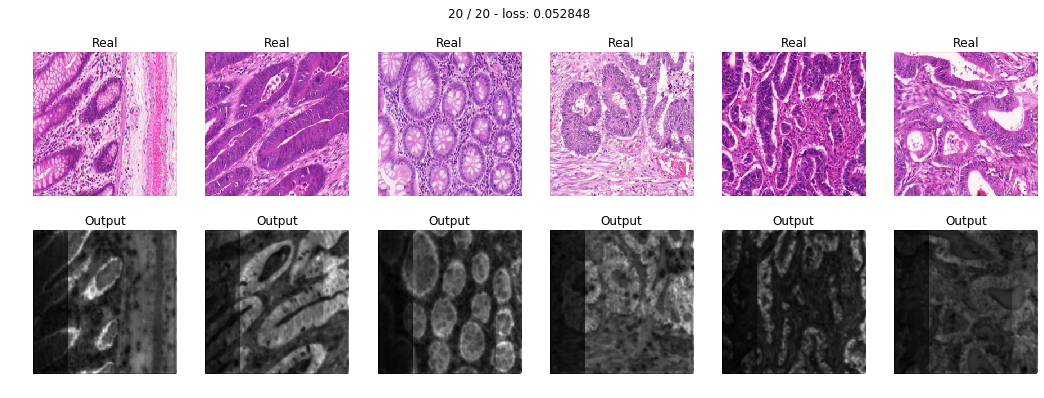

In [22]:
train(model, optim.Adam(model.parameters()), bce_loss, 20, data_tr, data_val)

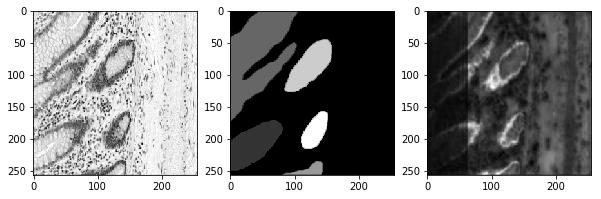

In [23]:
X_val, Y_val = next(iter(data_val))
#X_val_seg, Y_val_seg = next(iter(data_val_seg))


model.eval()  # testing mode
Y_pred = torch.sigmoid(model(X_val.to(device))).detach().cpu()
Y_pred[0]
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(131)
plt.imshow(X_val[0, 0], cmap='gray')


ax2 = plt.subplot(132)
plt.imshow(Y_val[0, 0], cmap='gray')

ax3 = plt.subplot(133)
plt.imshow(Y_pred[0, 0], cmap='gray')

#ax3 = plt.subplot(133)
#plt.imshow(Y_val_seg[0, 0], cmap='gray')



th = 0.5
#compute TP
#compute FP
#compute FN